## Autoregressive Predictor (AR-predictor)

If you want to use this notebook, please download or clone our GitHub project ([**tensor-learning**](https://github.com/xinychen/tensor-learning)) on your computer.

In [1]:
import numpy as np
from numpy.linalg import inv as inv
import matplotlib.pyplot as plt

%matplotlib inline

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>compute_mape</code>:</b> <font color="black">Compute the value of Mean Absolute Percentage Error (MAPE).</font></li>
<li><b><code>compute_rmse</code>:</b> <font color="black">Compute the value of Root Mean Square Error (RMSE).</font></li>
</ul>
</div>

> Note that $$\mathrm{MAPE}=\frac{1}{n} \sum_{i=1}^{n} \frac{\left|y_{i}-\hat{y}_{i}\right|}{y_{i}}, \quad\mathrm{RMSE}=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}},$$ where $n$ is the total number of estimated values, and $y_i$ and $\hat{y}_i$ are the actual value and its estimation, respectively.

In [2]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

### Define AR-predictor kernel

We devise a rolling prediction scheme for decorating `AR-predictor`, there are some necessary inputs:

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>pred_time_steps</code>:</b> <font color="black">Total number of time points we should predict.</font></li>
<li><b><code>time_horizon</code>:</b> <font color="black">Time horizon we should forecast for each rolling window.</font></li>
<li><b><code>back_time_steps</code>:</b> <font color="black">Total number of time points for training.</font></li>
</ul>
</div>

In [3]:
def ar4cast(mat, A, time_lags, time_horizon):
    mat_hat = np.zeros((mat.shape[0], time_horizon))
    for t in range(time_horizon):
        vec = np.einsum('ij, ij -> i', mat[:, - time_lags], A).reshape([mat.shape[0], 1])
        mat = np.append(mat, vec, axis = 1)
    return mat[:, - time_horizon :]

def predictor(dense_mat, pred_time_steps, time_horizon, back_time_steps, time_lags):
    """AR-predictor kernel."""
    T = dense_mat.shape[1]
    start_time = T - pred_time_steps
    max_lag = max(time_lags)
    d = len(time_lags)
    mat_hat = np.zeros((dense_mat.shape[0], pred_time_steps))
    for t in range(int(pred_time_steps / time_horizon)):
        print('The current prediction step: {}'.format(t + 1))
        start = start_time - back_time_steps + (t + 1) * time_horizon
        end = start_time  + t * time_horizon
        temp = dense_mat[:, start : end]
        if t == 0:
            A = np.zeros((dense_mat.shape[0], d))
            ind = np.zeros((d, temp.shape[1] - max_lag), dtype = np.int_)
            for i in range(d):
                ind[i, :] = np.arange(max_lag - time_lags[i], temp.shape[1] - time_lags[i])
            for m in range(dense_mat.shape[0]):
                Qm = temp[m, ind].T
                A[m, :] = np.linalg.pinv(Qm) @ temp[m, max_lag :]
        mat_hat[:, t * time_horizon : (t + 1) * time_horizon] = ar4cast(temp, A, time_lags, time_horizon)
#         fig = plt.figure(figsize = (14, 3.1))
#         plt.plot(np.mean(mat_hat, axis = 0), color = "r")
#         plt.plot(np.mean(dense_mat[:, start_time :], axis = 0), color = "b")
#         plt.show()
#         print()
        
    small_dense_mat = dense_mat[:, start_time : dense_mat.shape[1]]
    pos = np.where(small_dense_mat != 0)
    mape = compute_mape(small_dense_mat[pos], mat_hat[pos])
    rmse = compute_rmse(small_dense_mat[pos], mat_hat[pos])
    print('Prediction MAPE: {:.6}'.format(mape))
    print('Prediction RMSE: {:.6}'.format(rmse))
    
    return mat_hat, mape, rmse

### PeMS data

We evaluate model on PeMS traffic speed data set.

In [4]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')

We use `predictor` to predict time series (time horizon: 9) without missing values and measure performance metrics on the ground truth.

In [5]:
import time
start = time.time()
time_horizon = 9
pred_time_steps = 160 * time_horizon
time_intervals = 288
back_time_steps = 28 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
mat_hat, mape, rmse = predictor(dense_mat, pred_time_steps, time_horizon, back_time_steps, time_lags)
end = time.time()
print('Running time: %d seconds'%(end - start))

The current prediction step: 1
The current prediction step: 2
The current prediction step: 3
The current prediction step: 4
The current prediction step: 5
The current prediction step: 6
The current prediction step: 7
The current prediction step: 8
The current prediction step: 9
The current prediction step: 10
The current prediction step: 11
The current prediction step: 12
The current prediction step: 13
The current prediction step: 14
The current prediction step: 15
The current prediction step: 16
The current prediction step: 17
The current prediction step: 18
The current prediction step: 19
The current prediction step: 20
The current prediction step: 21
The current prediction step: 22
The current prediction step: 23
The current prediction step: 24
The current prediction step: 25
The current prediction step: 26
The current prediction step: 27
The current prediction step: 28
The current prediction step: 29
The current prediction step: 30
The current prediction step: 31
The current predi

For this notebook example, we visualize traffic speeds and their forecasts of the given road segment. If you want to see the predicted traffic speed curves, please run the following code cell.

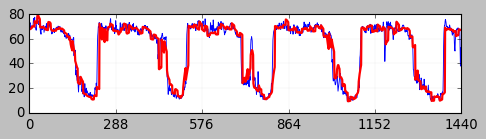

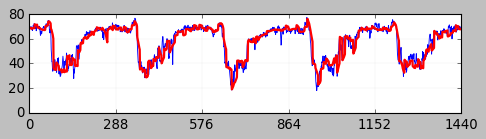

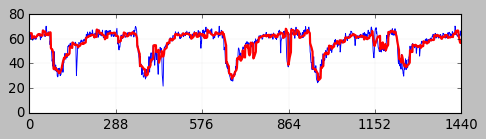

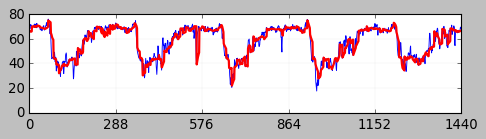

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

axis_font = {'fontname':'Arial'}
plt.style.use('classic')
for i in [1, 2, 3, 4]:
    fig = plt.figure(figsize=(6, 1.5))
    ax = fig.add_axes([0.05, 0.12, 0.90, 0.82])
    plt.plot(dense_mat[i, -pred_time_steps:], color = 'b', linewidth = 0.8)
    plt.plot(mat_hat[i, -pred_time_steps:], color = 'r', linewidth = 2)
    plt.xticks(np.arange(0, 288 * 5 + 1, 288))
    plt.yticks(np.arange(0, 80 + 1, 20))
    ax.set_xlim([0, pred_time_steps]) 
    ax.set_ylim([0, 80])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.5)
    plt.show()

### Guangzhou data

We evaluate model on Guangzhou traffic speed data set.

In [7]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
dense_tensor = tensor['tensor']

dense_mat = dense_tensor.reshape([dense_tensor.shape[0], dense_tensor.shape[1] * dense_tensor.shape[2]])

We use `predictor` to predict time series (time horizon: 12) without missing values and measure performance metrics on the ground truth.

In [8]:
import time
start = time.time()
time_horizon = 12
pred_time_steps = 84 * time_horizon
time_intervals = 144
back_time_steps = 28 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
mat_hat, mape, rmse = predictor(dense_mat, pred_time_steps, time_horizon, back_time_steps, time_lags)
end = time.time()
print('Running time: %d seconds'%(end - start))

The current prediction step: 1
The current prediction step: 2
The current prediction step: 3
The current prediction step: 4
The current prediction step: 5
The current prediction step: 6
The current prediction step: 7
The current prediction step: 8
The current prediction step: 9
The current prediction step: 10
The current prediction step: 11
The current prediction step: 12
The current prediction step: 13
The current prediction step: 14
The current prediction step: 15
The current prediction step: 16
The current prediction step: 17
The current prediction step: 18
The current prediction step: 19
The current prediction step: 20
The current prediction step: 21
The current prediction step: 22
The current prediction step: 23
The current prediction step: 24
The current prediction step: 25
The current prediction step: 26
The current prediction step: 27
The current prediction step: 28
The current prediction step: 29
The current prediction step: 30
The current prediction step: 31
The current predi

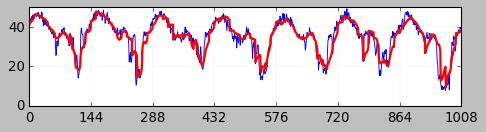

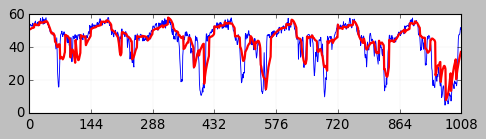

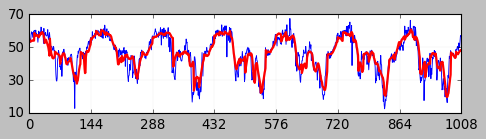

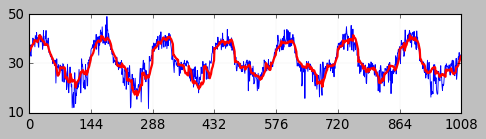

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

axis_font = {'fontname':'Arial'}
plt.style.use('classic')
for i in [0, 1, 2, 3]:
    fig = plt.figure(figsize=(6, 1.5))
    ax = fig.add_axes([0.05, 0.12, 0.90, 0.82])
    plt.plot(dense_mat[i, -pred_time_steps:], color = 'b', linewidth = 0.8)
    plt.plot(mat_hat[i, -pred_time_steps:], color = 'r', linewidth = 2)
    plt.xticks(np.arange(0, 144 * 7 + 1, 144))
    if i == 0:
        plt.yticks(np.arange(0, 50 + 1, 20))
    elif i == 1:
        plt.yticks(np.arange(0, 70 + 1, 20))
    elif i == 2:
        plt.yticks(np.arange(10, 70 + 1, 20))
    elif i == 3:
        plt.yticks(np.arange(10, 50 + 1, 20))
    ax.set_xlim([0, pred_time_steps])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.5)
    plt.show()

### Electricity data

In [10]:
dense_mat = np.load('../datasets/Electricity-data-set/electricity35.npy')

In [11]:
import time
start = time.time()
time_horizon = 6
pred_time_steps = 20 * time_horizon
time_intervals = 24
back_time_steps = 28 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
mat_hat, mape, rmse = predictor(dense_mat, pred_time_steps, time_horizon, back_time_steps, time_lags)
end = time.time()
print('Running time: %d seconds'%(end - start))

The current prediction step: 1
The current prediction step: 2
The current prediction step: 3
The current prediction step: 4
The current prediction step: 5
The current prediction step: 6
The current prediction step: 7
The current prediction step: 8
The current prediction step: 9
The current prediction step: 10
The current prediction step: 11
The current prediction step: 12
The current prediction step: 13
The current prediction step: 14
The current prediction step: 15
The current prediction step: 16
The current prediction step: 17
The current prediction step: 18
The current prediction step: 19
The current prediction step: 20
Prediction MAPE: 0.155582
Prediction RMSE: 1082.94
Running time: 0 seconds


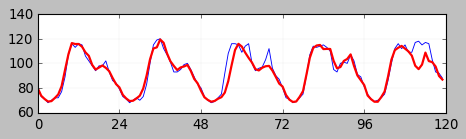

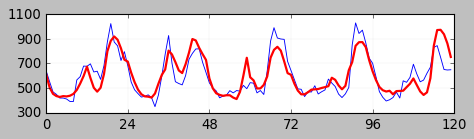

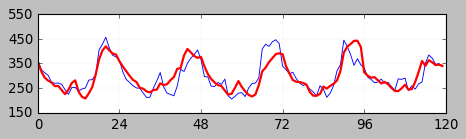

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

axis_font = {'fontname':'Arial'}
plt.style.use('classic')
for i in [1, 3, 4]:
    fig = plt.figure(figsize=(6, 1.5))
    ax = fig.add_axes([0.10, 0.12, 0.85, 0.82])
    plt.plot(dense_mat[i, -pred_time_steps:], color = 'b', linewidth = 0.8)
    plt.plot(mat_hat[i, -pred_time_steps:], color = 'r', linewidth = 2)
    plt.xticks(np.arange(0, 24 * 5 + 1, 24))
    if i == 1:
        plt.yticks(np.arange(60, 140 + 1, 20))
    elif i == 3:
        plt.yticks(np.arange(300, 1100 + 1, 200))
    elif i == 4:
        plt.yticks(np.arange(150, 600 + 1, 100))
    ax.set_xlim([0, pred_time_steps])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.5)
    plt.show()

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>